In [131]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid

import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

In [132]:
transform = transforms.ToTensor()

In [133]:
train_data = datasets.MNIST(root='/cnn_data', train=True, download=True, transform=transform)

In [134]:
test_data = datasets.MNIST(root='/cnn_data', train=False, download=True, transform=transform)

In [135]:
train_data

Dataset MNIST
    Number of datapoints: 60000
    Root location: /cnn_data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [136]:
# Create a small batch size for images...let's say 10
train_loader = DataLoader(train_data, batch_size=10, shuffle=True)
test_loader = DataLoader(test_data, batch_size=10, shuffle=False)

Feature batch shape: torch.Size([10, 1, 28, 28]) torch.Size([10, 1, 28, 28])
Labels batch shape: torch.Size([10])


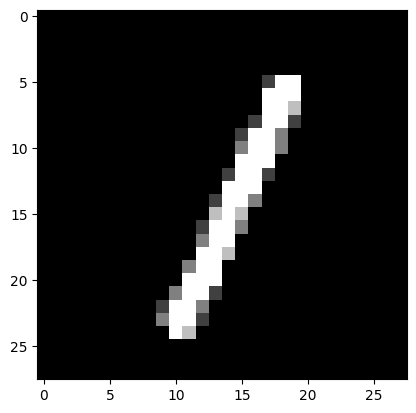

Label: 1


In [137]:
train_features, train_labels = next(iter(train_loader))
print(f"Feature batch shape: {train_features.size()} {train_features.shape}")
print(f"Labels batch shape: {train_labels.size()}")

img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")

In [138]:
import torch.nn as nn
import torch.nn.functional as F
class ConvolutionNetwork(nn.Module):
    def __init__(self):
        super(ConvolutionNetwork, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 3, 1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 3, 1)
        self.fc1 = nn.Linear(400, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)  # 10 because of 10 classes 

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 400)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return F.log_softmax(x, dim=1)

In [139]:
# import torch.nn as nn
# import torch.nn.functional as F
# class ConvolutionNetwork(nn.Module):
#     def __init__(self):
#         super().__init__()
#         self.conv1 = nn.Conv2d(1,6,3,1)
#         self.conv2 = nn.Conv2d(6,16,3,1)

#             # Fully Connected Layer
#         self.fc1 = nn.Linear(400, 120)
#         self.fc2 = nn.Linear(120, 84)
#         self.fc3 = nn.Linear(84, 10)

#     def forward(self, X):
#         X = F.relu(self.conv1(X))
#         X = F.max_pool2d(X,2,2) # 2x2 kernal and stride 2
#         # Second Pass
#         X = F.relu(self.conv2(X))
#         X = F.max_pool2d(X,2,2) # 2x2 kernal and stride 2

#         # Re-View to flatten it out
#         X = X.view(-1, 400) # negative one so that we can vary the batch size

#         # Fully Connected Layers
#         X = F.relu(self.fc1(X))
#         X = F.relu(self.fc2(X))
#         X = self.fc3(X)
#         return F.log_softmax(X, dim=1)

In [140]:
torch.manual_seed(41)
model = ConvolutionNetwork()
model

ConvolutionNetwork(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [141]:

import torchinfo
from torchinfo import summary

summary(model, input_size=[1, 1, 28, 28])

Layer (type:depth-idx)                   Output Shape              Param #
ConvolutionNetwork                       [1, 10]                   --
├─Conv2d: 1-1                            [1, 6, 26, 26]            60
├─MaxPool2d: 1-2                         [1, 6, 13, 13]            --
├─Conv2d: 1-3                            [1, 16, 11, 11]           880
├─MaxPool2d: 1-4                         [1, 16, 5, 5]             --
├─Linear: 1-5                            [1, 120]                  48,120
├─Linear: 1-6                            [1, 84]                   10,164
├─Linear: 1-7                            [1, 10]                   850
Total params: 60,074
Trainable params: 60,074
Non-trainable params: 0
Total mult-adds (M): 0.21
Input size (MB): 0.00
Forward/backward pass size (MB): 0.05
Params size (MB): 0.24
Estimated Total Size (MB): 0.29

In [142]:
# loss funcitn 
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [143]:
epochs = 5

train_losses = []
test_losses = []
train_correct = []
test_correct = []


for i in range(epochs):
    trn_corr = 0 
    tst_corr = 0
    for b, (X_train, y_train) in enumerate(train_loader):
        b += 1

        # Forward pass
        y_pred = model(X_train)

        # Compute loss
        loss = criterion(y_pred, y_train)

        predicted = torch.max(y_pred.data, dim=1)[1]
        batch_corr = (predicted == y_train).sum()
        trn_corr += batch_corr

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if b%600 == 0:
            print(f'Epoch: {i} | Batch: {b} | Loss: {loss.item():.4f}')
    
    train_losses.append(loss)
    train_correct.append(trn_corr)

    #test
    with torch.no_grad():
        for b, (X_test, y_test) in enumerate(test_loader):
            y_val = model(X_test)

            predicted = torch.max(y_val.data, dim=1)[1]
            tst_corr += (predicted == y_test).sum()
    
    loss = criterion(y_val, y_test)
    test_losses.append(loss)
    test_correct.append(tst_corr)
    


Epoch: 0 | Batch: 600 | Loss: 0.5418
Epoch: 0 | Batch: 1200 | Loss: 0.2202
Epoch: 0 | Batch: 1800 | Loss: 0.1758
Epoch: 0 | Batch: 2400 | Loss: 0.0030
Epoch: 0 | Batch: 3000 | Loss: 0.0172
Epoch: 0 | Batch: 3600 | Loss: 0.0020
Epoch: 0 | Batch: 4200 | Loss: 0.0151
Epoch: 0 | Batch: 4800 | Loss: 0.6768
Epoch: 0 | Batch: 5400 | Loss: 0.0016
Epoch: 0 | Batch: 6000 | Loss: 0.1879
Epoch: 1 | Batch: 600 | Loss: 0.0291
Epoch: 1 | Batch: 1200 | Loss: 0.0065
Epoch: 1 | Batch: 1800 | Loss: 0.0046
Epoch: 1 | Batch: 2400 | Loss: 0.0184
Epoch: 1 | Batch: 3000 | Loss: 0.3671
Epoch: 1 | Batch: 3600 | Loss: 0.0107
Epoch: 1 | Batch: 4200 | Loss: 0.0054
Epoch: 1 | Batch: 4800 | Loss: 0.0013
Epoch: 1 | Batch: 5400 | Loss: 0.2262
Epoch: 1 | Batch: 6000 | Loss: 0.1042
Epoch: 2 | Batch: 600 | Loss: 0.0002
Epoch: 2 | Batch: 1200 | Loss: 0.0002
Epoch: 2 | Batch: 1800 | Loss: 0.3406
Epoch: 2 | Batch: 2400 | Loss: 0.0010
Epoch: 2 | Batch: 3000 | Loss: 0.0003
Epoch: 2 | Batch: 3600 | Loss: 0.0007
Epoch: 2 | Batc

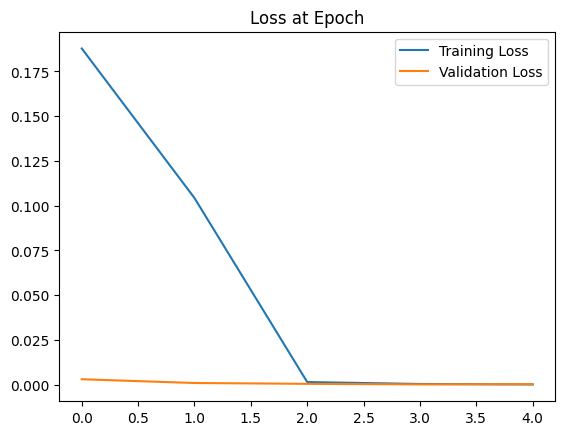

In [144]:

# Graph the loss at epoch
train_losses = [tl.item() for tl in train_losses]
plt.plot(train_losses, label="Training Loss")
plt.plot(test_losses, label="Validation Loss")
plt.title("Loss at Epoch")
plt.legend()

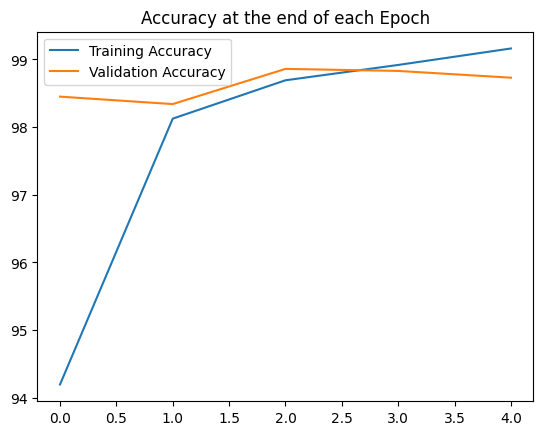

In [145]:

# graph the accuracy at the end of each epoch
plt.plot([t/600 for t in train_correct], label="Training Accuracy")
plt.plot([t/100 for t in test_correct], label="Validation Accuracy")
plt.title("Accuracy at the end of each Epoch")
plt.legend()

In [146]:
test_load_everything = DataLoader(test_data, batch_size=10000, shuffle=False)


In [147]:
with torch.no_grad():
  correct = 0
  for X_test, y_test in test_load_everything:
    y_val = model(X_test)
    predicted = torch.max(y_val, 1)[1]
    correct += (predicted == y_test).sum()

In [148]:

# Did for correct
correct.item()/len(test_data)*100

98.72999999999999

In [157]:
test_data[2000][1]

6

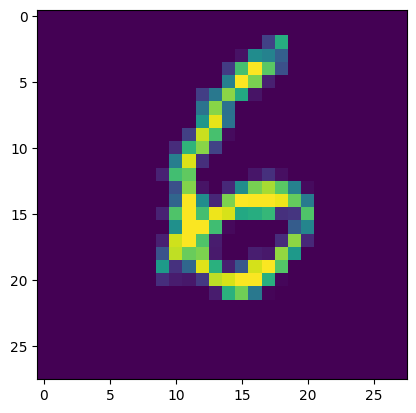

In [158]:
plt.imshow(test_data[2000][0].reshape(28,28))

In [159]:
import torch
model.eval()
with torch.no_grad():
    new_prediction = model(test_data[2000][0])

In [160]:
new_prediction.argmax()

tensor(6)